In [1]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series
import math
import time

In [2]:
k = 230 #W/m°C 
L = 0.030 #m
t = 0.03 #m
h = 8750 #W/m²°C Convecção Forçada
T0 = 80 #°C
T_infinito = 25 #°C
w = 1 #m

In [3]:
meshx = 60
deltax = L/(meshx-0.5)

meshy = 60
deltay = (t/2)/(meshy-1)

In [4]:
#Solução exata 1D

x_plot = np.zeros(meshx)
y_plot = np.zeros(meshy)
T_exato = np.zeros(meshx)


x_plot[0] = deltax/2
for x in range(1,meshx):
    x_plot[x] = x_plot[x-1] + deltax
    
y_plot[0] = 0
for y in range(1,meshy):
    y_plot[y] = y_plot[y-1] + deltay
    

m= (2*h/(k*t))**0.5

eta = math.tanh(m*L)/(m*L)

for x in range(meshx):
    T_exato[x] = math.cosh(m*(L-x_plot[x]))/math.cosh(m*L) * (T0-T_infinito) + T_infinito
    
q_exato = (h*2*w*k*t*w)**0.5*(T0-T_infinito)*math.tanh(m*L)



In [5]:
eta

0.6003892140188192

In [6]:
q_exato

17336.238554793403

In [7]:
#Numérico 2D
tempo_inicial = time.time()
Matrix_coef_a = np.zeros((meshx*meshy,meshx*meshy))
Matrix_coef_b = np.zeros((meshx*meshy,1))
T=np.zeros((meshx*meshy,1))
ae = np.zeros((meshx,meshy))
aw = np.zeros((meshx,meshy))
an = np.zeros((meshx,meshy))
aS = np.zeros((meshx,meshy))
ap = np.zeros((meshx,meshy))
b = np.zeros((meshx,meshy))
 
for x in range(meshx):
    for y in range(meshy):
        #volume inferior esquerdo
        if (x == 0) and (y==0):
            aw[x,y] = 0
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = 0
            aw_f = k*(deltay/2)*w/(deltax/2)
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f
            b[x,y] = aw_f*T0
            
        #volume inferior direito
        if (x == 0) and (y==meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = 0
            an[x,y] = k*(deltax/2)*w/deltay
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
        #volume superior esquerdo
        if (x == meshx-1) and (y==0):
            aw[x,y] = 0
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = 0
            aS[x,y] = k*deltax*w/deltay
            an_f = h*deltax*w
            aw_f = k*(deltay/2)*w/(deltax/2)
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f + an_f
            b[x,y] = aw_f*T0 + an_f*T_infinito
            
        #volume superior direito
        if (x == meshx-1) and (y==meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = 0
            an[x,y] = 0
            aS[x,y] = k*(deltax/2)*w/(deltay) 
            an_f = h*(deltax/2)*w
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes na face esquerda
        if (y == 0) and (x>0) and (x<meshx-1):
            aw[x,y] = 0
            ae[x,y] = k*deltay*w/deltax
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = k*deltax*w/deltay
            aw_f = k*deltay*w/(deltax/2)
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f
            b[x,y] = aw_f*T0
            
        #volumes na face direita
        if (y == meshy-1) and (x>0) and (x<meshx-1):
            aw[x,y] = k*deltay*w/deltax
            ae[x,y] = 0
            an[x,y] = k*(deltax/2)*w/deltay
            aS[x,y] = k*(deltax/2)*w/deltay            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0  
            
        #volumes no norte
        if (x == meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = 0
            aS[x,y] = k*deltax*w/deltay 
            an_f = h*deltax*w
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes no sul
        if (x == 0) and (y>0) and (y<meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
            
        #volumes internos
        if (x>0) and (x < meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = k*deltay*w/deltax
            ae[x,y] = aw[x,y]
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = an[x,y]            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
                     
#montando a matriz de coeficientes:
cont = 0
for x in range(meshx):
    for y in range(meshy):
        Matrix_coef_a[cont,cont] = ap[x,y]
        Matrix_coef_a[cont,cont-1] = -aw[x,y]
        
        if cont < meshx*meshy-1:
            Matrix_coef_a[cont,cont+1] = -ae[x,y]
        if cont < meshx*meshy-meshy:   
            Matrix_coef_a[cont,cont+meshy] = -an[x,y]
        if cont >meshy-1:
            Matrix_coef_a[cont,cont-meshy] = -aS[x,y]
        
        
        Matrix_coef_b[cont,0] = b[x,y]
        cont += 1
        
    
T = solve(Matrix_coef_a,Matrix_coef_b)

T_plot = np.zeros((meshx,meshy))

#transformando o vetor Temperatura em Matriz

cont = 0
for x in range(meshx):
    for y in range(meshy):
        T_plot[x,y] = T[cont]
        cont += 1

q_cond =np.zeros(meshx)
q_cond[0] = (T0 - T_plot[0,0]) * k *(deltay/2)*w/(deltax/2)
for x in range(1,meshx-1):
    q_cond[x] = (T0 - T_plot[x,0]) * k *deltay*w/(deltax/2)
q_cond[meshx-1] = (T0 - T_plot[meshx-1,0]) * k *(deltay/2)*w/(deltax/2)

q_conv = np.zeros(meshy)
for y in range(meshy-1):
    q_conv[y] = (T_plot[meshx-1,y] - T_infinito) * h * deltax*w
q_conv[meshy-1] = (T_plot[meshx-1,meshy-1] - T_infinito) * h * (deltax/2)*w

q_cond_total = sum(q_cond) *2
q_conv_total = sum(q_conv) *2

tempo_final = time.time()

tempo = tempo_final-tempo_inicial


In [8]:
q_cond_total

15830.206539353054

In [9]:
q_conv_total

15830.206539409322

In [10]:
tempo

2.860628604888916

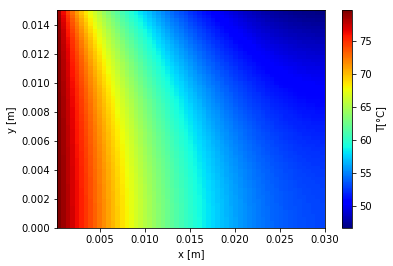

In [11]:
#Grafico 2D
%matplotlib inline
        
X,Y = np.meshgrid(x_plot,y_plot)

fig, ax = plt.subplots()

#ax.contourf(X,Y,T_plot,200,'linestyle')
p = ax.pcolor(X, Y, T_plot, cmap='jet', vmin=abs(T_plot).min(), vmax=abs(T_plot).max())
cb = fig.colorbar(p, ax=ax)

cb.set_label('T[°C]')

ax.set_ylabel('y [m]')
ax.set_xlabel('x [m]')




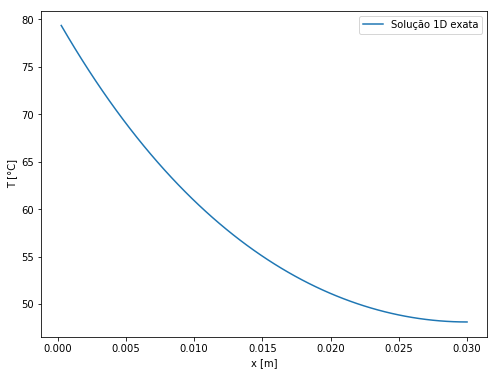

In [12]:
#Grafico 1D
%matplotlib inline

fig = plt.figure(figsize=(8,6))
axis = fig.add_subplot(111)    


axis.plot(x_plot,T_exato,label='Solução 1D exata')
axis.set_ylabel('T [°C]')
axis.set_xlabel('x [m]')
axis.set_title('')
axis.legend(loc='best')

In [13]:
#Tentativa numérico 1D

T_1D = np.zeros(meshx)
A=t*w


 #volumes na face esquerda
        
    aw[x] = 0
    ae[x] = k*A/deltax    
    aw_f = k*A/(deltax/2)
    ap[x] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f
    b[x] = aw_f*T0

    #volumes na face direita
    if (y == meshy-1) and (x>0) and (x<meshx-1):
    aw[x] = k*deltay*w/deltax
    ae[x] = 0
    an[x] = k*(deltax/2)*w/deltay
    aS[x] = k*(deltax/2)*w/deltay            
    ap[x] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
    b[x] = 0  